In [744]:
# basic python tools for numbers and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# statistics tools
import scipy.stats as stats

# scale and one hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# machine learning tools
from sklearn import preprocessing 

# from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from sklearn import metrics

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
import itertools
import copy

# Clear warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# show plots inline
%matplotlib inline

In [745]:
# Plot styling and display options
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

In [746]:
# The quality of df_new is not good (too few samples)
# So we do not 
df_x = pd.read_csv('df_x.csv')
df_y = pd.read_csv('dfy.csv')

In [747]:
# Combine to a unified y - mental health level
df_y['mental_health'] = 0

df_y['CIDPSCOR'] = df_y['CIDPSCOR'].replace(5,0)  # Originally "no" (problem) is encoded as 5, now we change to 0
df_y['CIDGSCOR'] = df_y['CIDGSCOR'].replace(5,0)
df_y['CIDDSCOR'] = df_y['CIDDSCOR'].replace(5,0)

df_y.mental_health = df_y.CIDPSCOR + df_y.CIDGSCOR + df_y.CIDDSCOR

In [748]:
df_y.drop(['CIDPSCOR','CIDGSCOR','CIDDSCOR'],axis=1,inplace=True)

In [749]:
# Convert mental_health to 0-1 variable
df_y['mental_health'][df_y['mental_health']>=1] = 1

In [750]:
df_y.to_csv('ycombined.csv',index=False,sep=',')

In [751]:
data = pd.merge(df_y, df_x, on = 'SEQN', left_index=True,sort=False)

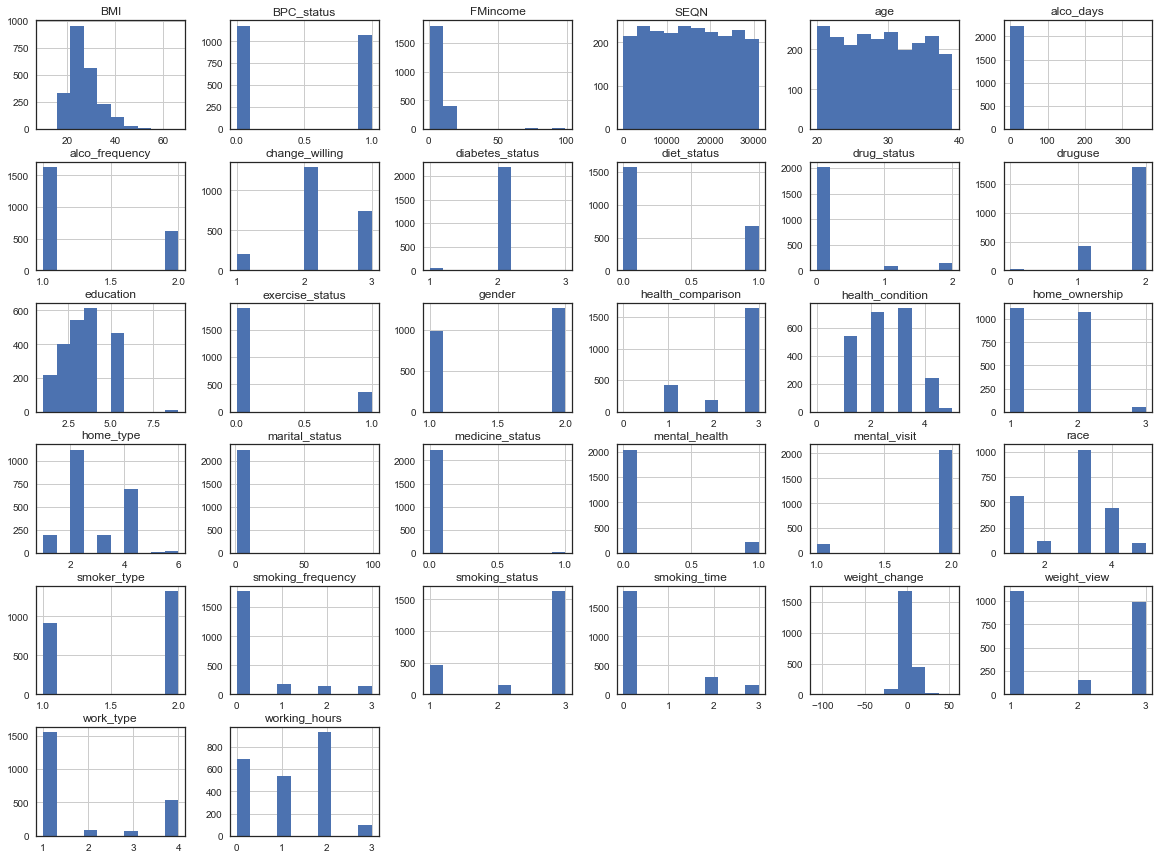

In [752]:
data.hist(figsize=(20,15))
plt.show()

In [753]:
# As there are very few 77/99 (the refused to answer and don't know) values
# We choose to replace them directly by median values

data['FMincome'] = data['FMincome'].replace(77, data['FMincome'].median()).\
                                    replace(99, data['FMincome'].median())
data['education'] = data['education'].replace(7, data['education'].median()).\
                                        replace(9, data['education'].median())
data['marital_status'] = data['marital_status'].replace(77, data['marital_status'].median()).\
                                    replace(99, data['marital_status'].median())

In [754]:
def scaler(col):
    X = np.array(col)
    X = preprocessing.scale(X)
    return X

In [755]:
# These variables are using 2 to encode 0

data['gender'] = data['gender'].replace(2,0)  # Originally female = 2, now we change to 0
data['druguse'] = data['druguse'].replace(2,0)  # Originally 2 means no drug using
data['mental_visit'] = data['mental_visit'].replace(2,0)  # Similar to the above 
data['smoker_type'] = data['smoker_type'].replace(2,0)    # Similar to the above
data['alco_frequency'] = data['alco_frequency'].replace(2,0)  

In [756]:
# Scale the quantification variable
# Scaling will not change their distribution

data['age'] = scaler(data['age'])
data['alco_days'] = scaler(data['alco_days'])
data['BMI'] = scaler(data['BMI'])
data['weight_change'] = scaler(data['weight_change'])
data['alco_days'] = scaler(data['alco_days'])

In [757]:
# As there are too many categories in the income variable, we choose to split it into three categories.
# With regard to its percentiles, we can set 4 and 8 as two thresholds
# And drop the original variable

data['income_level'] = 2 # moderate income
data['income_level'][data['FMincome']<=4] = 1 # low income
data['income_level'][data['FMincome']>=8] = 3 # high income
data.drop('FMincome',axis=1,inplace=True)

In [758]:
# With regard to the categories' meanings, we can set 2 and 4 as two thresholds
# And then drop the original variable

data['education_level'] = 2 # moderate education
data['education_level'][data['education']<=1] = 1 # low education
data['education_level'][data['education']>=4] = 3 # high education
data.drop('education', axis=1, inplace=True)

In [759]:
# With regard to the 'marital_status's meanings, we split them into a new variable called 'partner_status'
# And then drop the original variable

data['partner_status'] = 2 # widowed, divorced or seperated
data['partner_status'][data['marital_status']==1] = 3 # have a partner (married)
data['partner_status'][data['marital_status']==6] = 3 # have a partner (living with a partner)
data['partner_status'][data['marital_status']==5] = 1 # single (never married)
data.drop('marital_status', axis=1, inplace=True)

In [760]:
data.to_csv('scaled_data.csv', index=False, sep=',')

In [761]:
data = pd.read_csv('scaled_data.csv')

In [762]:
# We give the variables a new sequence
# Arranged by 'SEQN', dependent variable, the independent variables (qualifier first, and then quantifier)

data = data[['SEQN','mental_health',\
             'gender','race','alco_frequency','drug_status',\
             'BPC_status','diet_status','exercise_status','medicine_status',\
             'diabetes_status','druguse','health_condition','health_comparison',\
             'mental_visit','home_type','home_ownership','smoker_type','smoking_status',\
             'smoking_frequency','smoking_time','work_type','working_hours',\
             'weight_view','change_willing','income_level','education_level','partner_status',\
             'age','alco_days','BMI','weight_change']]

In [763]:
data.to_csv('sequenced_data.csv', index=False, sep=',')

In [764]:
data = pd.read_csv('sequenced_data.csv')

Now, before we do one-hot encoding on our data set, we do some simple calculation and visualizations to see some properties of our data set

In [765]:
# Balanced data set?

target_count = data['mental_health'].value_counts()
target_count

0.0    2038
1.0     210
Name: mental_health, dtype: int64

In [766]:
# What is base line for prediction accuracy?

target_count[0]/(sum(target_count)) 

0.9065836298932385

In fact, this is not a balanced data set, so we need to use some methods to solve this problem. Before solving this problem, we check the correlation of our data.

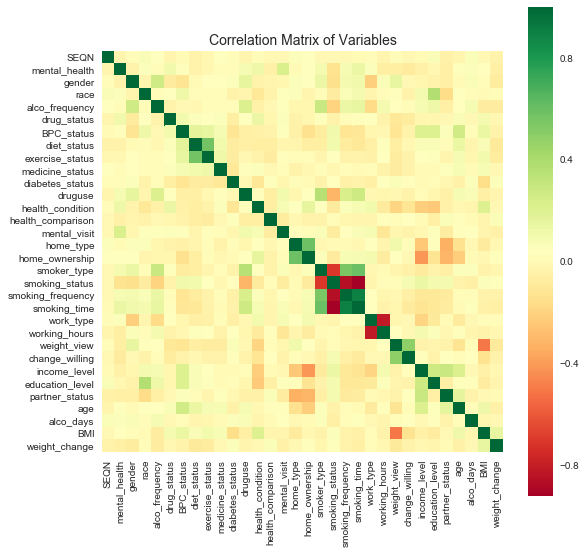

In [767]:
# Uncorrelated features are generally more powerful predictors
# This result is pretty satisfactory

corMat1 = data.corr()
pic3 = plt.subplots(figsize=(9, 9))
sns.heatmap(corMat1, annot=False, vmax=1, square=True, cmap="RdYlGn")
plt.title('Correlation Matrix of Variables', fontsize=14)
plt.show()

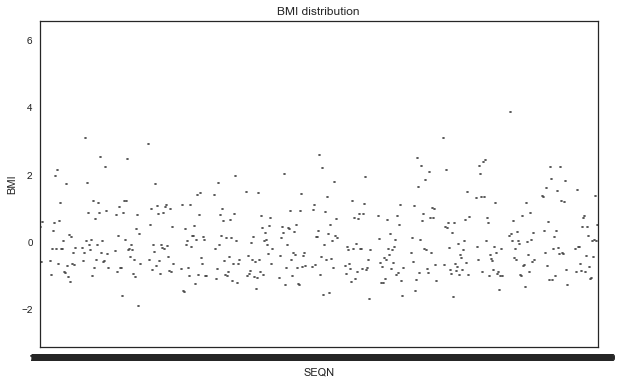

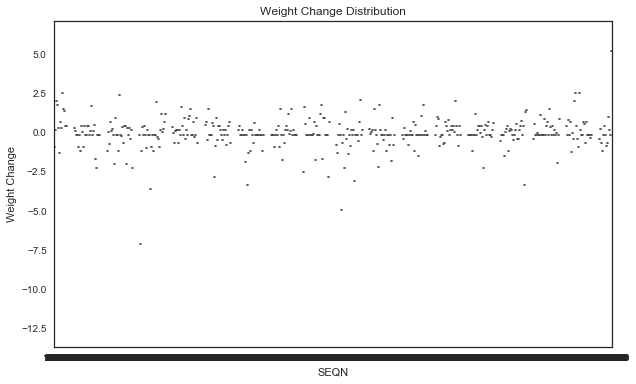

In [768]:
# We check the distribution of quantitative variables to make sure whether there are outliers

pic3 = sns.violinplot(data['SEQN'], data['BMI'])
plt.title('BMI distribution', fontsize=12)
plt.xlabel('SEQN')
plt.ylabel('BMI')
plt.show(pic3)

pic4  = sns.violinplot(data['SEQN'], data['weight_change'])
plt.title('Weight Change Distribution', fontsize=12)
plt.xlabel('SEQN')
plt.ylabel('Weight Change')
plt.show(pic4)

It's happy to find that there's pretty few outliers, but the distribution of these two variables are not uniform, making it possible to find some valuable information out of them.

<a id='sec5'></a>
___
## Machine Learning!
After some basic visualizations, we use machine learning models on our data set.

Now we will Model, Predict, and Choose from algorithms for classification. 
We will try using different classifiers to model and predict. 

We ultimately will choose the best model from:
1. Logistic Regression
2. K-Nearest Neighbors (KNN) 
3. Support Vector Machines (SVM)
4. Perceptron
5. XGBoost
6. Random Forest

### Setup Training and Validation Sets

In [769]:
X = data.iloc[:,2:]
Y = data.iloc[:,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=100)

train_df = pd.concat([pd.DataFrame(Y_train), X_train],axis=1)
test_df = pd.concat([pd.DataFrame(Y_test), X_test],axis=1)

X = train_df.drop('mental_health', axis=1) # Training & Validation data
Y = train_df['mental_health']              # Response / Target Variable

print(X.shape, Y.shape)

(1798, 30) (1798,)


In [770]:
# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation data during training. 
# This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(1438, 30) (1438,)
(360, 30) (360,)


___
> ### Scikit-Learn general ML workflow
> 1. __Instantiate__ model object
> 2. __Fit__ model to training data
> 3. __Predict & Evaluate__ predict output for data not used during training and compare predicitons against true output values to form an accuracy measure.

___

#### 1. Logistic Regression

In [771]:
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_train, Y_train)                                 # fit
Y_pred = logreg.predict(X_val)                               # predict
acc_logreg = sum(Y_pred == Y_val)/len(Y_val)*100             # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_logreg,2)),'%')

Logistic Regression labeling accuracy: 89.44 %


In [772]:
# we could also use scikit learn's method score
# that predicts and then compares to validation set labels
acc_log_2 = logreg.score(X_val, Y_val)                       # evaluate

print('Logistic Regression using built-in method:', str(round(acc_log_2*100,2)),'%')

Logistic Regression using built-in method: 89.44 %


#### 2. KNN

In [773]:
knn = KNeighborsClassifier(n_neighbors = 3)                  # instantiate
knn.fit(X_train, Y_train)                                    # fit
acc_knn = knn.score(X_val, Y_val)                            # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_knn*100,2)),'%')                                

K-Nearest Neighbors labeling accuracy: 87.5 %


#### 3. SVM

In [774]:
# Support Vector Machines Classifier (non-linear kernel)
svc = SVC()                                                  # instantiate
svc.fit(X_train, Y_train)                                    # fit
acc_svc = svc.score(X_val, Y_val)                            # predict + evaluate

print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

Support Vector Machines labeling accuracy: 89.17 %


#### 4. Perceptron

In [775]:
perceptron = Perceptron()                                    # instantiate 
perceptron.fit(X_train, Y_train)                             # fit
acc_perceptron = perceptron.score(X_val, Y_val)              # predict + evalaute

print('Perceptron labeling accuracy:', str(round(acc_perceptron*100,2)),'%')

Perceptron labeling accuracy: 13.89 %


#### 5. XGBoost

In [776]:
# XGBoost, same API as scikit-learn
gradboost = xgb.XGBClassifier(n_estimators=1000)             # instantiate
gradboost.fit(X_train, Y_train)                              # fit
acc_xgboost = gradboost.score(X_val, Y_val)                  # predict + evalute

print('XGBoost labeling accuracy:', str(round(acc_xgboost*100,2)),'%')

XGBoost labeling accuracy: 89.17 %


#### 6. Random Forest

In [777]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=500)   # instantiate
random_forest.fit(X_train, Y_train)                         # fit
acc_rf = random_forest.score(X_val, Y_val)                  # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_rf*100,2)),'%')

K-Nearest Neighbors labeling accuracy: 90.28 %


### Importance scores in the random forest model

Training accuracy Random Forest: 1.0


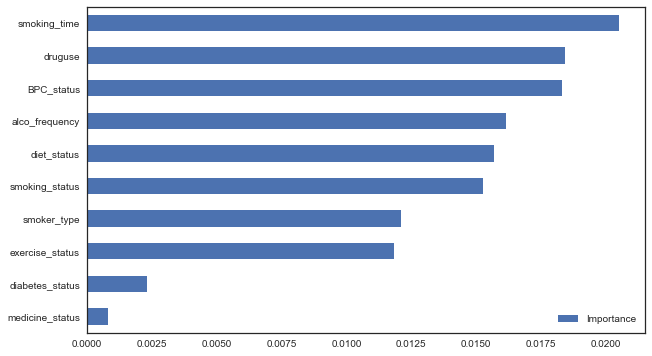

In [778]:
# Look at importance of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)

The random forest model is doing the best, so we check it on the test set.

In [779]:
# Check the accuracy of our chosen model on true test set
Y_predict = random_forest.predict(X_test)
acc_final = sum(Y_predict == Y_test)/len(Y_test)*100       
print('Final model (random forest) labeling accuracy:', str(round(acc_final,2)),'%')

Final model (random forest) labeling accuracy: 92.44 %


In [780]:
# Check the amount of zero in our final prediction
Counter(Y_predict)

Counter({0.0: 448, 1.0: 2})

Considering the amount of 0 and the fact that the accuracy of final model on test set is dramatically higher than that on the training set, our first stack of models are not good.

Now we firstly encode our categorical variables, do feature filtering, solve the problem of class imbalance, and train the model again.

### Encoding the data

In [781]:
def categorial_encoder(df):
    for idx,value in enumerate(df):
        df[value] = labelencoder_X.fit_transform(df[value])
        enc = OneHotEncoder()
        enc.fit(np.array(df[value]).reshape(-1,1))
        if enc.n_values_[0] >= 3:
            value_new = pd.DataFrame(enc.transform(np.array(df[value]).reshape(-1,1)).toarray())
            cols = []
            for i in range(1,enc.n_values_[0]+1):
                col_name = str(value)+str("_")+str(i)
                cols.append(col_name)
            
            value_new.columns = cols
            df = pd.concat([df,value_new],axis=1)
            df.drop(value,axis=1,inplace=True)
    return df

categorical_data = categorial_encoder(data.iloc[:,2:-4])

In [782]:
categorical_data.head()

,gender,alco_frequency,BPC_status,diet_status,exercise_status,medicine_status,druguse,mental_visit,smoker_type,race_1,race_2,race_3,race_4,race_5,drug_status_1,drug_status_2,drug_status_3,diabetes_status_1,diabetes_status_2,diabetes_status_3,health_condition_1,health_condition_2,health_condition_3,health_condition_4,health_condition_5,health_condition_6,health_comparison_1,health_comparison_2,health_comparison_3,health_comparison_4,home_type_1,home_type_2,home_type_3,home_type_4,home_type_5,home_type_6,home_ownership_1,home_ownership_2,home_ownership_3,smoking_status_1,smoking_status_2,smoking_status_3,smoking_frequency_1,smoking_frequency_2,smoking_frequency_3,smoking_frequency_4,smoking_time_1,smoking_time_2,smoking_time_3,smoking_time_4,work_type_1,work_type_2,work_type_3,work_type_4,working_hours_1,working_hours_2,working_hours_3,working_hours_4,weight_view_1,weight_view_2,weight_view_3,change_willing_1,change_willing_2,change_willing_3,income_level_1,income_level_2,income_level_3,education_level_1,education_level_2,education_level_3,partner_status_1,partner_status_2,partner_status_3
0,1,1,1,0,0,0,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,1,1,0,0,0,1,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,1,0,0,0,0,1,0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [783]:
categorized_data = pd.concat([data.iloc[:,0:2], categorical_data],axis=1)
categorized_data = pd.concat([categorized_data, data.iloc[:,-4:]],axis=1)
categorized_data.describe()

,SEQN,mental_health,gender,alco_frequency,BPC_status,diet_status,exercise_status,medicine_status,druguse,mental_visit,smoker_type,race_1,race_2,race_3,race_4,race_5,drug_status_1,drug_status_2,drug_status_3,diabetes_status_1,diabetes_status_2,diabetes_status_3,health_condition_1,health_condition_2,health_condition_3,health_condition_4,health_condition_5,health_condition_6,health_comparison_1,health_comparison_2,health_comparison_3,health_comparison_4,home_type_1,home_type_2,home_type_3,home_type_4,home_type_5,home_type_6,home_ownership_1,home_ownership_2,home_ownership_3,smoking_status_1,smoking_status_2,smoking_status_3,smoking_frequency_1,smoking_frequency_2,smoking_frequency_3,smoking_frequency_4,smoking_time_1,smoking_time_2,smoking_time_3,smoking_time_4,work_type_1,work_type_2,work_type_3,work_type_4,working_hours_1,working_hours_2,working_hours_3,working_hours_4,weight_view_1,weight_view_2,weight_view_3,change_willing_1,change_willing_2,change_willing_3,income_level_1,income_level_2,income_level_3,education_level_1,education_level_2,education_level_3,partner_status_1,partner_status_2,partner_status_3,age,alco_days,BMI,weight_change
count,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.00000,2248.000000,2248.000000,2248.00000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2248.000000,2.248000e+03,2.248000e+03,2.248000e+03,2.248000e+03
mean,15436.605872,0.093416,0.438612,0.725979,0.475979,0.298043,0.159698,0.006673,0.192171,0.076957,0.409253,0.251335,0.052046,0.453292,0.199288,0.044039,0.900356,0.035142,0.064502,0.019573,0.974644,0.005783,0.000890,0.239324,0.314947,0.328292,0.105872,0.010676,0.000445,0.189502,0.081851,0.728203,0.089858,0.499555,0.085409,0.309164,0.006228,0.009786,0.497331,0.477313,0.025356,0.20863,0.064502,0.726868,0.79137,0.078737,0.064947,0.064947,0.792705,0.006228,0.131673,0.069395,0.690391,0.038701,0.034698,0.236210,0.305160,0.238434,0.413701,0.042705,0.491993,0.068060,0.439947,0.093861,0.575623,0.330516,0.283363,0.334520,0.382117,0.097865,0.423043,0.479093,0.205961,0.128114,0.665925,-3.373142e-17,9.520607e-17,-4.692273e-16,-2.726170e-17
std,8874.873083,0.291080,0.496328,0.446119,0.499534,0.457500,0.366407,0.081431,0.394094,0.266583,0.491805,0.433877,0.222170,0.497924,0.399554,0.205228,0.299592,0.184180,0.245699,0.138558,0.157239,0.075842,0.029821,0.426766,0.464598,0.469696,0.307742,0.102795,0.021091,0.391994,0.274198,0.444985,0.286041,0.500111,0.279552,0.462252,0.078688,0.098463,0.500104,0.499596,0.157239,0.40642,0.245699,0.445667,0.40642,0.269387,0.246486,0.246486,0.405459,0.078688,0.338210,0.254181,0.462435,0.192924,0.183053,0.424847,0.460578,0.426221,0.492606,0.202235,0.500047,0.251906,0.496491,0.291700,0.494358,0.470504,0.450731,0.471927,0.486013,0.297198,0.494152,0.499674,0.404492,0.334291,0.471771,1.000222e+00,1.000222e+00,1.000222e+00,1.000222e+00
min,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.

In [784]:
categorized_data.to_csv('categorized_data.csv', index=False, sep=',')

In [785]:
data_categorized = pd.read_csv('categorized_data.csv')

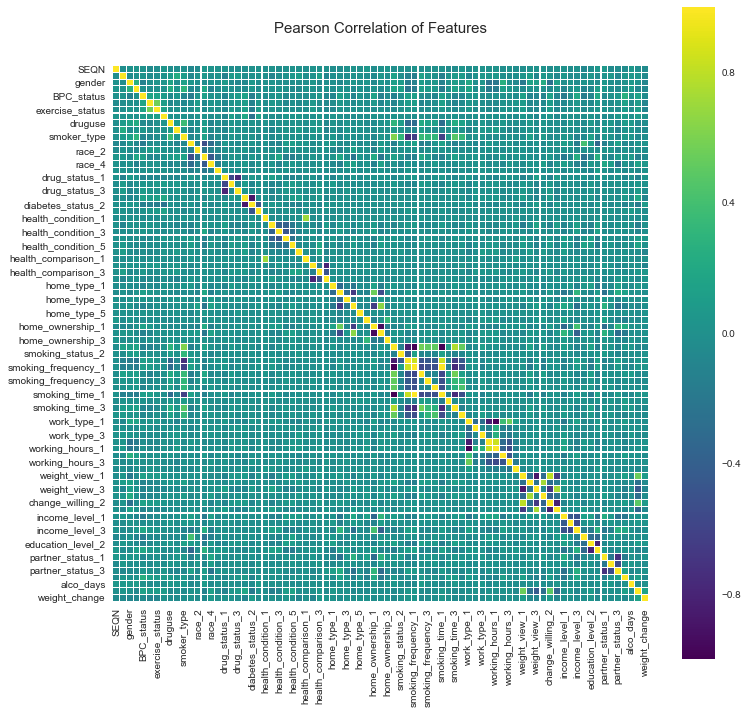

In [786]:
# We check the correlation among variables after encoding
# It's also a satisfying result

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data_categorized.corr().round(2),\
            linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            annot=False);

In [787]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

chosen = pd.DataFrame(RFE(estimator=LogisticRegression(), n_features_to_select=20).\
                fit_transform(data_categorized.iloc[:,2:], data_categorized.iloc[:,1]))
# Question: How to retain the column name?

In [788]:
# Split our data to training set and test set
X_train, X_test, y_train, y_test = train_test_split(data_categorized.iloc[:,2:],\
                                                    data_categorized.iloc[:,1],\
                                                    test_size = 0.2, random_state=100)

train_df = pd.concat([pd.DataFrame(y_train), X_train],axis=1)
test_df = pd.concat([pd.DataFrame(y_test), X_test],axis=1)

#### Firstly Check the performance of the original data set

In [789]:
print('The original performance of logistic Regression on this data set:',\
      LogisticRegression().fit(X_train, y_train).score(X_test, y_test)*100,'%')
print('The original performance of KNN on this data set:',\
      KNeighborsClassifier(n_neighbors = 3)  .fit(X_train, y_train).score(X_test, y_test)*100, '%')
print("The original performance of SVM on this data set:",\
      SVC().fit(X_train, y_train).score(X_test, y_test)*100, '%')
print("The original performance of XGBoost on this data set:",\
      xgb.XGBClassifier(n_estimators=1000).fit(X_train, y_train).score(X_test, y_test)*100, '%')
print("The original performance of random forest on this data set:",\
      RandomForestClassifier(n_estimators=500) .fit(X_train, y_train).score(X_test, y_test)*100, '%')

The original performance of logistic Regression on this data set: 91.77777777777779 %
The original performance of KNN on this data set: 90.66666666666666 %
The original performance of SVM on this data set: 92.44444444444444 %
The original performance of XGBoost on this data set: 90.0 %
The original performance of random forest on this data set: 92.66666666666666 %


#### Use RFE to modify the data set

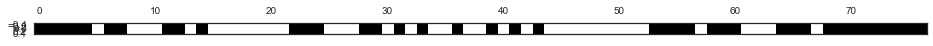

In [790]:
from sklearn.feature_selection import RFE

select = RFE(RandomForestClassifier(n_estimators=100, random_state=20), n_features_to_select=40)
#select = RFE(LogisticRegression(penalty="l1"), n_features_to_select=40)
#n_features_to_select参数设置要选择的特征数目,默认选一半

select.fit(X_train, y_train)
# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')

In [791]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

print("The modified performance of logistic regression on this data set:",\
      LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)*100, '%')
print("The modified performance of random forest on this data set:",\
      RandomForestClassifier(n_estimators=500) .fit(X_train_rfe, y_train).score(X_test_rfe, y_test)*100, '%')

print("Select score:", select.score(X_test, y_test))

The modified performance of logistic regression on this data set: 92.0 %
The modified performance of random forest on this data set: 92.66666666666666 %
Select score: 0.9288888888888889


In [792]:
# print(pd.DataFrame(X_train_rfe).columns)
# pd.DataFrame(X_train_rfe).hist(figsize=(20,10))
# plt.show()

#### Actually we cannot tell which the chosen variables are after running RFE - still need to search.

Now let's solve the class imbalance problem.

In [793]:
# Split training set so that we validate on 20% of the data
# Note that our algorithms will never have seen the validation data during training. 
# This is to evaluate how good our estimators are.
X_train, X_test, Y_train, Y_test = train_test_split(data_categorized.iloc[:,2:], data_categorized.iloc[:,1], test_size=0.2)

np.random.seed(1337) # set random seed for reproducibility

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(1438, 77) (1438,)
(360, 77) (360,)


In [794]:
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = SMOTE(random_state=60)
X_smo, y_smo = smo.fit_sample(X_train, Y_train)

from collections import Counter
print(Counter(y_smo))

Counter({1.0: 1316, 0.0: 1316})


In [795]:
logreg = LogisticRegression()                                # instantiate
logreg.fit(X_smo, y_smo)                                     # fit
Y_pred = logreg.predict(X_val)                               # predict
acc_log_2 = logreg.score(X_val, Y_val)                       # evaluate

print('Logistic Regression labeling accuracy:', str(round(acc_log_2*100,2)),'%')

Logistic Regression labeling accuracy: 72.78 %


In [796]:
knn = KNeighborsClassifier(n_neighbors = 3)                  # instantiate
knn.fit(X_smo, y_smo)                                        # fit
acc_knn = knn.score(X_val, Y_val)                            # predict + evaluate

print('K-Nearest Neighbors labeling accuracy:', str(round(acc_knn*100,2)),'%')                                

K-Nearest Neighbors labeling accuracy: 64.44 %


In [797]:
# Support Vector Machines Classifier (non-linear kernel)
svc = SVC()                                                  # instantiate
svc.fit(X_smo, y_smo)                                        # fit
acc_svc = svc.score(X_val, Y_val)                            # predict + evaluate

print('Support Vector Machines labeling accuracy:', str(round(acc_svc*100,2)),'%')

Support Vector Machines labeling accuracy: 76.94 %


In [798]:
perceptron = Perceptron()                                    # instantiate 
perceptron.fit(X_smo, y_smo)                                 # fit
acc_perceptron = perceptron.score(X_val, Y_val)              # predict + evalaute

print('Perceptron labeling accuracy:', str(round(acc_perceptron*100,2)),'%')

Perceptron labeling accuracy: 35.56 %


In [804]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=500)   # instantiate
random_forest.fit(X_smo, y_smo)                            # fit
acc_rf = random_forest.score(X_val, Y_val)                  # predict + evaluate

print('Random forest labeling accuracy:', str(round(acc_rf*100,2)),'%')

Random forest labeling accuracy: 90.56 %


#### The highest three are (by sequence): random forest, SVM and logistic regression, now we test them on test set.

In [807]:
# Check the accuracy of SVM on our test set

Y_predict_log = logreg.predict(X_test)
acc_final = sum(Y_predict_log == Y_test)/len(Y_test)*100       
print('SVM labeling accuracy:', str(round(acc_final,2)),'%')

SVM labeling accuracy: 70.44 %


In [806]:
# Check the accuracy of SVM on our test set

Y_predict_svc = svc.predict(X_test)
acc_final = sum(Y_predict_svc == Y_test)/len(Y_test)*100       
print('SVM labeling accuracy:', str(round(acc_final,2)),'%')

SVM labeling accuracy: 76.89 %


In [805]:
# Check the accuracy of random forest on our test set

Y_predict_rf = random_forest.predict(X_test)
acc_final = sum(Y_predict_rf == Y_test)/len(Y_test)*100       
print('Rrandom forest labeling accuracy:', str(round(acc_final,2)),'%')

Final model (random forest) labeling accuracy: 89.56 %
